In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **Download CIFAR-10 Dataset**

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)



# Define the split ratio
train_size = int(0.8 * len(trainset))  # 80% for training
val_size = len(trainset) - train_size  # Remaining 20% for validation

# Randomly split the training dataset into training and validation sets
train_set, val_set = random_split(trainset, [train_size, val_size])

debug_size = int(0.02 * len(trainset))
_, debug_set = random_split(trainset, [ len(trainset) - debug_size, debug_size])

debug_loader = torch.utils.data.DataLoader(
    debug_set, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


## **ResNet Model**

In [4]:
class SimpleBasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SimpleBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = out + identity
        out = F.relu(out)
        
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet_CIFAR10(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet_CIFAR10, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Changed kernel to 3x3
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Removed maxpool since it's not needed for CIFAR-10's small input size

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [5]:
class SubResNet_CIFAR10(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(SubResNet_CIFAR10, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Changed kernel to 3x3
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Removed maxpool since it's not needed for CIFAR-10's small input size
        layers_agg = []
        kernels = 64
        for i, blocks in  enumerate(layers):
            kernels = 64*(2**i)
            layers_agg.append(self._make_layer(block, kernels, blocks, stride = (2 if i > 0 else 1 )))
            
        self.layers = nn.Sequential(*layers_agg)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(kernels * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



## **Number of Layers in Resnet are caluculated as follows**

- 1 FC at the end
- 1 Conv layer in the begining
- BasicBlock: 2 conv Layer
- Each Layer could have multiple BasicBlocks

Example: ResNet_CIFAR10(BasicBlock,[2, 1, 1, 1])
1 conv in the begining + 1 fc at the end +
Layer1 : 2 Basicblocks => 4 Conv layer
Layer2 : 1 Basicblock => 2 Conv Layer
Layer3: 1 Basicblock => 2 conv Layer
Layer3 : 1 Basicblock => 2 conv Layer

Total Layer = 1 + 1 + 4 + 2 +2 +2 = 12
So, this is ResNet12 with Layer1 having 2 basicblocks

In [6]:
resnet_6 = ResNet_CIFAR10(SimpleBasicBlock,[1, 1, 1, 1])

In [7]:
resnet_6

ResNet_CIFAR10(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): SimpleBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): SimpleBasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer3): Sequential(
    (0): SimpleBasicBlock(
      (conv1): Conv2d(128, 256, k

In [8]:
resnet_4 = SubResNet_CIFAR10(SimpleBasicBlock,[1, 1])

In [9]:
resnet_3 = SubResNet_CIFAR10(SimpleBasicBlock,[1])

In [10]:
resnet_5 = SubResNet_CIFAR10(SimpleBasicBlock,[1, 1, 1])

In [11]:
resnet_10 = ResNet_CIFAR10(BasicBlock,[1, 1, 1, 1])

In [12]:
resnet_12 = ResNet_CIFAR10(BasicBlock,[2, 1, 1, 1])

In [13]:
resnet_14 = ResNet_CIFAR10(BasicBlock,[2, 2, 1, 1])

In [14]:
resnet_18 = ResNet_CIFAR10(BasicBlock,[2, 2, 2, 2])

## **Baseline Training for all Models**



In [15]:
# Training and testing utilities
def train(model, device, train_loader, optimizer, criterion, epoch, train_losses, model_name):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    
    if epoch%10 == 0 or (epoch + 1)%100 ==0:
      # Specify a path to save the model and optimizer state
      save_path = model_name + "_" + str(epoch) + ".pth"

      # Save model and optimizer state
      torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch': epoch,  
          'loss': average_loss 
      }, save_path)
      print(f"Model and optimizer state saved to {save_path}")


def test(model, device, test_loader, criterion, test_losses):
    model.to(device)
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    average_loss = test_loss / len(test_loader)
    test_losses.append(average_loss)
    print(f'Test set: Average loss: {average_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')


In [16]:
def training_process(model, device, model_name = None, num_epochs = None, checkpoint = None):
  criterion = nn.CrossEntropyLoss()       # Cross-entropy loss for classification
  optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
  start_epoch = 0
  if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    
  model.to(device)
  train_losses = []
  validation_losses = []
  iters = 100
  for epoch in range(start_epoch, start_epoch + iters):
      # train(model, device, debug_loader, optimizer, criterion, epoch, train_losses, model_name)
      # test(model, device, debug_loader, criterion, validation_losses)
      train(model, device, trainloader, optimizer, criterion, epoch, train_losses, model_name)
      test(model, device, valloader, criterion, validation_losses)
  num_epochs[model_name] = start_epoch + iters
  torch.save({
       'train_losses' : train_losses,
      'validation_losses': validation_losses 
  }, model_name + "losses_log.pth" )

      


In [17]:
models = [resnet_6, resnet_10, resnet_12, resnet_14, resnet_18 ]
model_names = ["resnet_6", "resnet_10", "resnet_12", "resnet_14", "resnet_18"]
num_epochs = {
    "resnet_10": 0,
    "resnet_12": 0,
    "resnet_14": 0,
    "resnet_18": 0
}


In [18]:
training_process(resnet_5, device, model_name = "resnet_5", num_epochs = num_epochs, checkpoint = None)

Train Epoch: 0 [0/40000] Loss: 2.416047
Train Epoch: 0 [12800/40000] Loss: 1.705838
Train Epoch: 0 [25600/40000] Loss: 1.305433
Train Epoch: 0 [38400/40000] Loss: 1.264144
Model and optimizer state saved to resnet_5_0.pth
Test set: Average loss: 1.4536, Accuracy: 4802/10000 (48%)
Train Epoch: 1 [0/40000] Loss: 1.292858
Train Epoch: 1 [12800/40000] Loss: 1.353574
Train Epoch: 1 [25600/40000] Loss: 1.331978
Train Epoch: 1 [38400/40000] Loss: 1.111342
Test set: Average loss: 1.3134, Accuracy: 5141/10000 (51%)
Train Epoch: 2 [0/40000] Loss: 1.290457
Train Epoch: 2 [12800/40000] Loss: 1.066424
Train Epoch: 2 [25600/40000] Loss: 1.201609
Train Epoch: 2 [38400/40000] Loss: 1.082253
Test set: Average loss: 1.2871, Accuracy: 5596/10000 (56%)
Train Epoch: 3 [0/40000] Loss: 1.005947
Train Epoch: 3 [12800/40000] Loss: 1.118325
Train Epoch: 3 [25600/40000] Loss: 1.081483
Train Epoch: 3 [38400/40000] Loss: 1.017100
Test set: Average loss: 1.2328, Accuracy: 5602/10000 (56%)
Train Epoch: 4 [0/40000] L

In [17]:
training_process(resnet_6, device, model_name = "resnet_6", num_epochs = num_epochs, checkpoint = None)

Train Epoch: 0 [0/40000] Loss: 2.327128
Train Epoch: 0 [12800/40000] Loss: 1.343617
Train Epoch: 0 [25600/40000] Loss: 1.262428
Train Epoch: 0 [38400/40000] Loss: 1.169177
Model and optimizer state saved to resnet_6_0.pth
Test set: Average loss: 1.3069, Accuracy: 5138/10000 (51%)
Train Epoch: 1 [0/40000] Loss: 1.282403
Train Epoch: 1 [12800/40000] Loss: 1.319398
Train Epoch: 1 [25600/40000] Loss: 1.275887
Train Epoch: 1 [38400/40000] Loss: 1.069305
Test set: Average loss: 1.1047, Accuracy: 6075/10000 (61%)
Train Epoch: 2 [0/40000] Loss: 0.988319
Train Epoch: 2 [12800/40000] Loss: 0.892918
Train Epoch: 2 [25600/40000] Loss: 0.965714
Train Epoch: 2 [38400/40000] Loss: 1.008353
Test set: Average loss: 1.1742, Accuracy: 5695/10000 (57%)
Train Epoch: 3 [0/40000] Loss: 1.178771
Train Epoch: 3 [12800/40000] Loss: 0.902931
Train Epoch: 3 [25600/40000] Loss: 0.921620
Train Epoch: 3 [38400/40000] Loss: 0.713728
Test set: Average loss: 0.9392, Accuracy: 6707/10000 (67%)
Train Epoch: 4 [0/40000] L

In [ ]:
test_losses = []
criterion = nn.CrossEntropyLoss()
test(resnet_6, device, testloader, criterion, test_losses)


In [19]:
training_process(resnet_10, device, model_name = "resnet_10", num_epochs = num_epochs)

Train Epoch: 0 [0/40000] Loss: 2.346573
Train Epoch: 0 [12800/40000] Loss: 1.572238
Train Epoch: 0 [25600/40000] Loss: 1.455735
Train Epoch: 0 [38400/40000] Loss: 1.014596
Model and optimizer state saved to resnet_10_0.pth
Test set: Average loss: 1.1732, Accuracy: 5851/10000 (59%)
Train Epoch: 1 [0/40000] Loss: 1.095714
Train Epoch: 1 [12800/40000] Loss: 1.038665
Train Epoch: 1 [25600/40000] Loss: 0.882148
Train Epoch: 1 [38400/40000] Loss: 0.788883
Test set: Average loss: 0.9442, Accuracy: 6701/10000 (67%)
Train Epoch: 2 [0/40000] Loss: 0.809136
Train Epoch: 2 [12800/40000] Loss: 0.895464
Train Epoch: 2 [25600/40000] Loss: 0.640356
Train Epoch: 2 [38400/40000] Loss: 0.688749
Test set: Average loss: 0.9183, Accuracy: 6847/10000 (68%)
Train Epoch: 3 [0/40000] Loss: 0.860298
Train Epoch: 3 [12800/40000] Loss: 0.652339
Train Epoch: 3 [25600/40000] Loss: 0.668030
Train Epoch: 3 [38400/40000] Loss: 0.604754
Test set: Average loss: 0.7173, Accuracy: 7500/10000 (75%)
Train Epoch: 4 [0/40000] 

In [23]:
criterion = nn.CrossEntropyLoss()
test(resnet_10, device, testloader, criterion, [])

Test set: Average loss: 0.5738, Accuracy: 9036/10000 (90%)


In [25]:
training_process(resnet_4, device, model_name = "resnet_4", num_epochs = num_epochs, checkpoint = None)

Train Epoch: 0 [0/40000] Loss: 2.351166
Train Epoch: 0 [12800/40000] Loss: 1.716797
Train Epoch: 0 [25600/40000] Loss: 1.507795
Train Epoch: 0 [38400/40000] Loss: 1.469503
Model and optimizer state saved to resnet_4_0.pth
Test set: Average loss: 1.5818, Accuracy: 4155/10000 (42%)
Train Epoch: 1 [0/40000] Loss: 1.520447
Train Epoch: 1 [12800/40000] Loss: 1.333768
Train Epoch: 1 [25600/40000] Loss: 1.386377
Train Epoch: 1 [38400/40000] Loss: 1.326321
Test set: Average loss: 1.4482, Accuracy: 4687/10000 (47%)
Train Epoch: 2 [0/40000] Loss: 1.353321
Train Epoch: 2 [12800/40000] Loss: 1.521052
Train Epoch: 2 [25600/40000] Loss: 1.320117
Train Epoch: 2 [38400/40000] Loss: 1.370008
Test set: Average loss: 1.3586, Accuracy: 5048/10000 (50%)
Train Epoch: 3 [0/40000] Loss: 1.366642
Train Epoch: 3 [12800/40000] Loss: 1.329609
Train Epoch: 3 [25600/40000] Loss: 1.287956
Train Epoch: 3 [38400/40000] Loss: 1.170611
Test set: Average loss: 1.2779, Accuracy: 5547/10000 (55%)
Train Epoch: 4 [0/40000] L

In [ ]:
resnet_10.load_state_dict(checkpoint['model_state_dict'])


In [27]:
training_process(resnet_3, device, model_name = "resnet_3", num_epochs = num_epochs, checkpoint = None)

Train Epoch: 0 [0/40000] Loss: 2.412797
Train Epoch: 0 [12800/40000] Loss: 1.955773
Train Epoch: 0 [25600/40000] Loss: 1.937438
Train Epoch: 0 [38400/40000] Loss: 1.814156
Model and optimizer state saved to resnet_3_0.pth
Test set: Average loss: 1.8147, Accuracy: 3338/10000 (33%)
Train Epoch: 1 [0/40000] Loss: 1.819320
Train Epoch: 1 [12800/40000] Loss: 1.631811
Train Epoch: 1 [25600/40000] Loss: 1.691714
Train Epoch: 1 [38400/40000] Loss: 1.541362
Test set: Average loss: 1.7098, Accuracy: 3627/10000 (36%)
Train Epoch: 2 [0/40000] Loss: 1.720704
Train Epoch: 2 [12800/40000] Loss: 1.662979
Train Epoch: 2 [25600/40000] Loss: 1.641073
Train Epoch: 2 [38400/40000] Loss: 1.447204
Test set: Average loss: 1.5800, Accuracy: 4274/10000 (43%)
Train Epoch: 3 [0/40000] Loss: 1.471786
Train Epoch: 3 [12800/40000] Loss: 1.459599
Train Epoch: 3 [25600/40000] Loss: 1.419310
Train Epoch: 3 [38400/40000] Loss: 1.369659
Test set: Average loss: 1.5753, Accuracy: 4241/10000 (42%)
Train Epoch: 4 [0/40000] L

## **Knowledge distillation training**

Choosing all the models bigger than student as teacher model

In [45]:
# Training and testing utilities
def train_with_kd( teacher, student, train_loader, epoch, T, soft_target_loss_weight, ce_loss_weight, device, optimizer, train_losses, model_name):
    ce_loss = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    
    
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        with torch.no_grad():
            teacher_logits = teacher(data)
        
        student_logits = student(data)

        #Soften the student logits by applying softmax first and log() second
        soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
        soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

        # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
        soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

        # Calculate the true label loss
        label_loss = ce_loss(student_logits, target)

        # Weighted sum of the two losses
        loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    
    if epoch%10 == 0 or (epoch + 1)%100 ==0:
      # Specify a path to save the model and optimizer state
      save_path = model_name + "_" + str(epoch) + ".pth"

      # Save model and optimizer state
      torch.save({
          'model_state_dict': student.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch': epoch,  
          'loss': average_loss 
      }, save_path)
      print(f"Model and optimizer state saved to {save_path}")


In [92]:
def training_process_with_kd( teacher, student, device, model_name = None, num_epochs = None, checkpoint = None):
  criterion = nn.CrossEntropyLoss()       # Cross-entropy loss for classification
  optimizer = optim.Adam( student.parameters(), lr=0.001)  # Adam optimizer
  start_epoch = 0
  if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    student.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    
  student.to(device)
  teacher.to(device)
  
  train_losses = []
  validation_losses = []
  iters = 100
  T = 2.0
  soft_target_loss_weight =  0.25
  ce_loss_weight = 0.75
  for epoch in range(start_epoch, start_epoch + iters):
      # train_with_kd( teacher, student, debug_loader, epoch, T, soft_target_loss_weight, ce_loss_weight, device, optimizer, train_losses, model_name)
      # test(student, device, debug_loader, criterion, validation_losses)
      train_with_kd( teacher, student, trainloader, epoch, T, soft_target_loss_weight, ce_loss_weight, device, optimizer, train_losses, model_name)
      test(student, device, valloader, criterion, validation_losses)
  num_epochs[model_name] = start_epoch + iters
  torch.save({
       'train_losses' : train_losses,
      'validation_losses': validation_losses 
  }, model_name + "losses_log.pth" )

      


In [93]:
kd_resnet_3 = SubResNet_CIFAR10(SimpleBasicBlock,[1])
kd_resnet_4 = SubResNet_CIFAR10(SimpleBasicBlock,[1, 1])
kd_resnet_5 = SubResNet_CIFAR10(SimpleBasicBlock,[1, 1, 1])
kd_resnet_6 = ResNet_CIFAR10(SimpleBasicBlock,[1, 1, 1, 1])

In [94]:
# checkpoint = torch.load("resnet_6_99.pth")
# resnet_6.load_state_dict(checkpoint['model_state_dict'])

In [95]:
# criterion = nn.CrossEntropyLoss()
# test(resnet_6, device, trainloader, criterion, [])

In [96]:
checkpoint = torch.load("resnet_10_99.pth")
resnet_10.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [97]:
training_process_with_kd( resnet_10, kd_resnet_3, device, "kd_resnet_3", num_epochs)

Train Epoch: 0 [0/40000] Loss: 4.105308
Train Epoch: 0 [12800/40000] Loss: 3.328153
Train Epoch: 0 [25600/40000] Loss: 3.325638
Train Epoch: 0 [38400/40000] Loss: 3.057939
Model and optimizer state saved to kd_resnet_3_0.pth
Test set: Average loss: 1.7784, Accuracy: 3475/10000 (35%)
Train Epoch: 1 [0/40000] Loss: 3.049794
Train Epoch: 1 [12800/40000] Loss: 3.175088
Train Epoch: 1 [25600/40000] Loss: 3.005641
Train Epoch: 1 [38400/40000] Loss: 3.002051
Test set: Average loss: 1.6959, Accuracy: 3792/10000 (38%)
Train Epoch: 2 [0/40000] Loss: 2.970850
Train Epoch: 2 [12800/40000] Loss: 2.803141
Train Epoch: 2 [25600/40000] Loss: 2.985331
Train Epoch: 2 [38400/40000] Loss: 2.505444
Test set: Average loss: 1.5752, Accuracy: 4238/10000 (42%)
Train Epoch: 3 [0/40000] Loss: 2.776691
Train Epoch: 3 [12800/40000] Loss: 2.928274
Train Epoch: 3 [25600/40000] Loss: 2.764834
Train Epoch: 3 [38400/40000] Loss: 2.541300
Test set: Average loss: 1.5922, Accuracy: 4253/10000 (43%)
Train Epoch: 4 [0/40000

In [98]:
training_process_with_kd( resnet_10, kd_resnet_4, device, "kd_resnet_4", num_epochs)

Train Epoch: 0 [0/40000] Loss: 4.008984
Train Epoch: 0 [12800/40000] Loss: 3.060602
Train Epoch: 0 [25600/40000] Loss: 2.854797
Train Epoch: 0 [38400/40000] Loss: 2.672015
Model and optimizer state saved to kd_resnet_4_0.pth
Test set: Average loss: 1.5576, Accuracy: 4253/10000 (43%)
Train Epoch: 1 [0/40000] Loss: 2.786486
Train Epoch: 1 [12800/40000] Loss: 2.495261
Train Epoch: 1 [25600/40000] Loss: 2.301055
Train Epoch: 1 [38400/40000] Loss: 2.463018
Test set: Average loss: 1.4326, Accuracy: 4996/10000 (50%)
Train Epoch: 2 [0/40000] Loss: 2.335501
Train Epoch: 2 [12800/40000] Loss: 2.218081
Train Epoch: 2 [25600/40000] Loss: 2.239007
Train Epoch: 2 [38400/40000] Loss: 2.422265
Test set: Average loss: 1.3974, Accuracy: 5160/10000 (52%)
Train Epoch: 3 [0/40000] Loss: 2.171887
Train Epoch: 3 [12800/40000] Loss: 2.119812
Train Epoch: 3 [25600/40000] Loss: 2.161797
Train Epoch: 3 [38400/40000] Loss: 2.016621
Test set: Average loss: 1.2563, Accuracy: 5641/10000 (56%)
Train Epoch: 4 [0/40000

In [99]:
training_process_with_kd( resnet_10, kd_resnet_5, device, "kd_resnet_5", num_epochs)

Train Epoch: 0 [0/40000] Loss: 4.042995
Train Epoch: 0 [12800/40000] Loss: 2.799779
Train Epoch: 0 [25600/40000] Loss: 2.623857
Train Epoch: 0 [38400/40000] Loss: 2.111462
Model and optimizer state saved to kd_resnet_5_0.pth
Test set: Average loss: 1.4512, Accuracy: 4880/10000 (49%)
Train Epoch: 1 [0/40000] Loss: 2.510530
Train Epoch: 1 [12800/40000] Loss: 2.043852
Train Epoch: 1 [25600/40000] Loss: 2.138404
Train Epoch: 1 [38400/40000] Loss: 2.268765
Test set: Average loss: 1.3297, Accuracy: 5287/10000 (53%)
Train Epoch: 2 [0/40000] Loss: 2.040987
Train Epoch: 2 [12800/40000] Loss: 2.192461
Train Epoch: 2 [25600/40000] Loss: 1.955956
Train Epoch: 2 [38400/40000] Loss: 1.538359
Test set: Average loss: 1.6104, Accuracy: 4944/10000 (49%)
Train Epoch: 3 [0/40000] Loss: 1.826044
Train Epoch: 3 [12800/40000] Loss: 1.889507
Train Epoch: 3 [25600/40000] Loss: 1.671304
Train Epoch: 3 [38400/40000] Loss: 1.820486
Test set: Average loss: 1.4661, Accuracy: 5559/10000 (56%)
Train Epoch: 4 [0/40000

Train Epoch: 66 [38400/40000] Loss: 0.708067
Test set: Average loss: 0.6685, Accuracy: 8123/10000 (81%)
Train Epoch: 67 [0/40000] Loss: 0.563711
Train Epoch: 67 [12800/40000] Loss: 0.629954
Train Epoch: 67 [25600/40000] Loss: 0.702111
Train Epoch: 67 [38400/40000] Loss: 0.606049
Test set: Average loss: 0.6502, Accuracy: 8149/10000 (81%)
Train Epoch: 68 [0/40000] Loss: 0.708887
Train Epoch: 68 [12800/40000] Loss: 0.423015
Train Epoch: 68 [25600/40000] Loss: 0.648805
Train Epoch: 68 [38400/40000] Loss: 0.623335
Test set: Average loss: 0.7864, Accuracy: 7854/10000 (79%)
Train Epoch: 69 [0/40000] Loss: 0.818273
Train Epoch: 69 [12800/40000] Loss: 0.559871
Train Epoch: 69 [25600/40000] Loss: 0.680432
Train Epoch: 69 [38400/40000] Loss: 0.746580
Test set: Average loss: 0.6540, Accuracy: 8099/10000 (81%)
Train Epoch: 70 [0/40000] Loss: 0.466959
Train Epoch: 70 [12800/40000] Loss: 0.721196
Train Epoch: 70 [25600/40000] Loss: 0.533237
Train Epoch: 70 [38400/40000] Loss: 0.367475
Model and optim

In [100]:
training_process_with_kd( resnet_10, kd_resnet_6, device, "kd_resnet_6", num_epochs)

Train Epoch: 0 [0/40000] Loss: 4.099324


Train Epoch: 0 [12800/40000] Loss: 2.459518
Train Epoch: 0 [25600/40000] Loss: 2.304938
Train Epoch: 0 [38400/40000] Loss: 2.081652
Model and optimizer state saved to kd_resnet_6_0.pth
Test set: Average loss: 1.3995, Accuracy: 5307/10000 (53%)
Train Epoch: 1 [0/40000] Loss: 2.175921
Train Epoch: 1 [12800/40000] Loss: 1.946054
Train Epoch: 1 [25600/40000] Loss: 1.660017
Train Epoch: 1 [38400/40000] Loss: 1.643989
Test set: Average loss: 1.1667, Accuracy: 6098/10000 (61%)
Train Epoch: 2 [0/40000] Loss: 1.813283
Train Epoch: 2 [12800/40000] Loss: 1.903141
Train Epoch: 2 [25600/40000] Loss: 1.629189
Train Epoch: 2 [38400/40000] Loss: 1.711635
Test set: Average loss: 1.3341, Accuracy: 5787/10000 (58%)
Train Epoch: 3 [0/40000] Loss: 1.693970
Train Epoch: 3 [12800/40000] Loss: 1.891927
Train Epoch: 3 [25600/40000] Loss: 1.541695
Train Epoch: 3 [38400/40000] Loss: 1.642891
Test set: Average loss: 1.0083, Accuracy: 6614/10000 (66%)
Train Epoch: 4 [0/40000] Loss: 1.378318
Train Epoch: 4 [12800/4

In [101]:
criterion = nn.CrossEntropyLoss()
test(kd_resnet_6, device, testloader, criterion, [])

Test set: Average loss: 0.6055, Accuracy: 8677/10000 (87%)


In [102]:
test(kd_resnet_5, device, testloader, criterion, [])

Test set: Average loss: 0.7534, Accuracy: 8185/10000 (82%)


In [103]:
test(kd_resnet_4, device, testloader, criterion, [])

Test set: Average loss: 1.1086, Accuracy: 7131/10000 (71%)


In [104]:
test(kd_resnet_3, device, testloader, criterion, [])

Test set: Average loss: 1.1827, Accuracy: 6207/10000 (62%)


## **Visualization**

In [32]:
import matplotlib.pyplot as plt

def visualize_loss_curve(model_name):
    """
    Plots training and validation loss over epochs.
    """
    path = model_name + "losses_log.pth"
    
    
    checkpoint = torch.load(path)
    train_losses = checkpoint['train_losses']
    val_losses =  checkpoint['validation_losses']
    save_path = "/teamspace/studios/this_studio/KnowledgeDistillation/plots/" + model_name+".png"
    
    epochs = range(1, len(train_losses) + 1)  # Create an array for the number of epochs

    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot training and validation loss
    plt.plot(epochs, train_losses, 'b', label='Training Loss')  # 'b' stands for blue
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')  # 'r' stands for red

    plt.title('Training and Validation Loss')  # Add a title to the plot
    plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
    plt.ylabel('Loss')     # Label the y-axis as 'Loss'
    
    plt.legend()  # Add a legend to differentiate the curves

    plt.grid(True)  # Enable grid for better readability
    
    # Save the plot if a file path is provided
    if save_path:
        plt.savefig(save_path, format='png')  # Save the plot in PNG format (or other supported formats)
        print(f"Plot saved as {save_path}")
    
    plt.show()  # Display the plot

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotsresnet_3.png


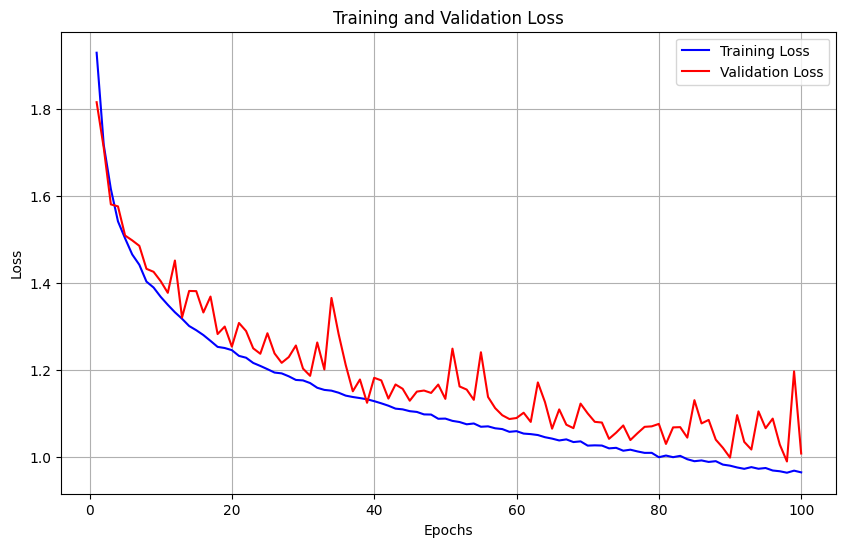

In [23]:
visualize_loss_curve("resnet_3")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotsresnet_4.png


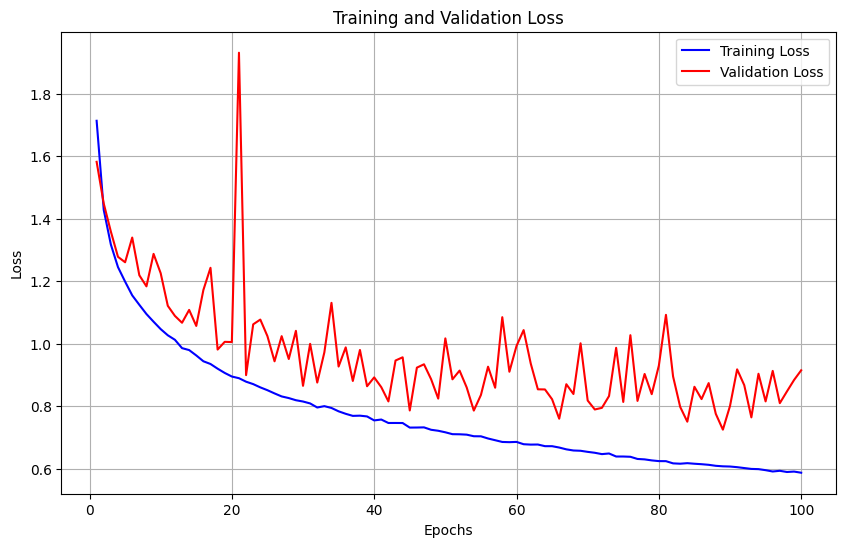

In [24]:
visualize_loss_curve("resnet_4")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotsresnet_5.png


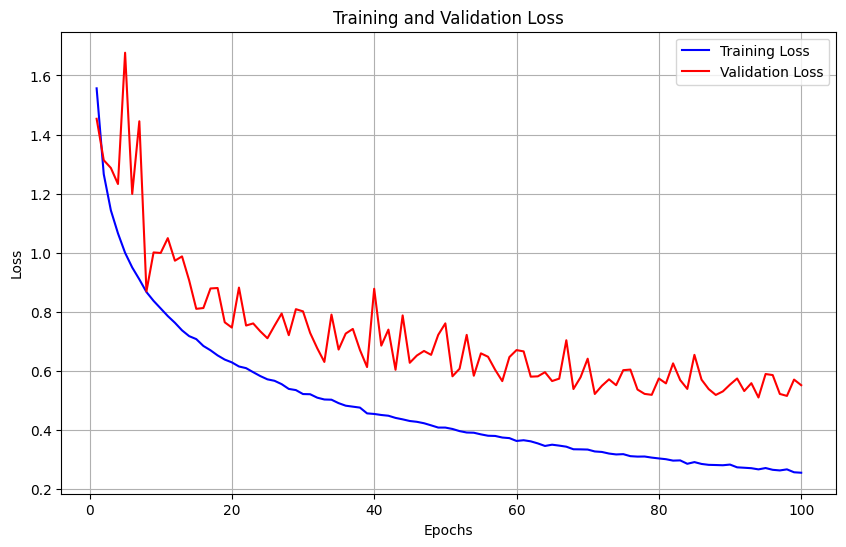

In [25]:
visualize_loss_curve("resnet_5")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotsresnet_6.png


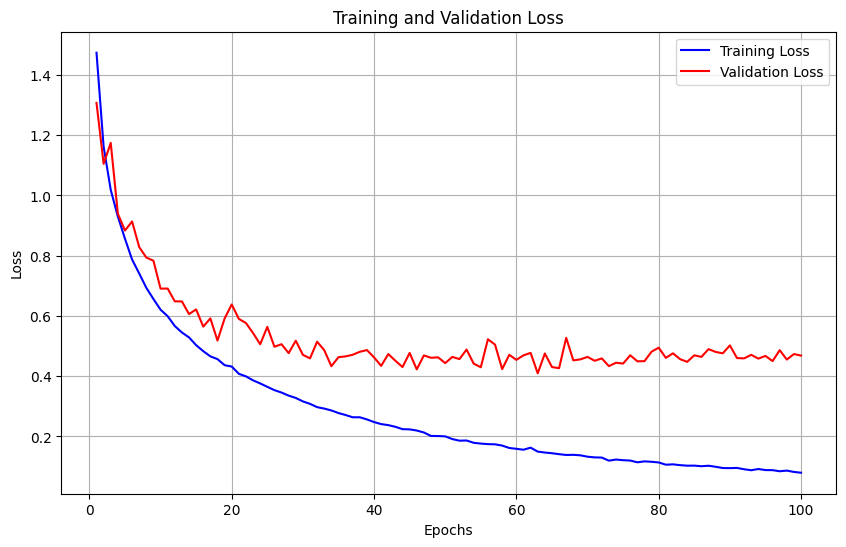

In [26]:
visualize_loss_curve("resnet_6")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotsresnet_10.png


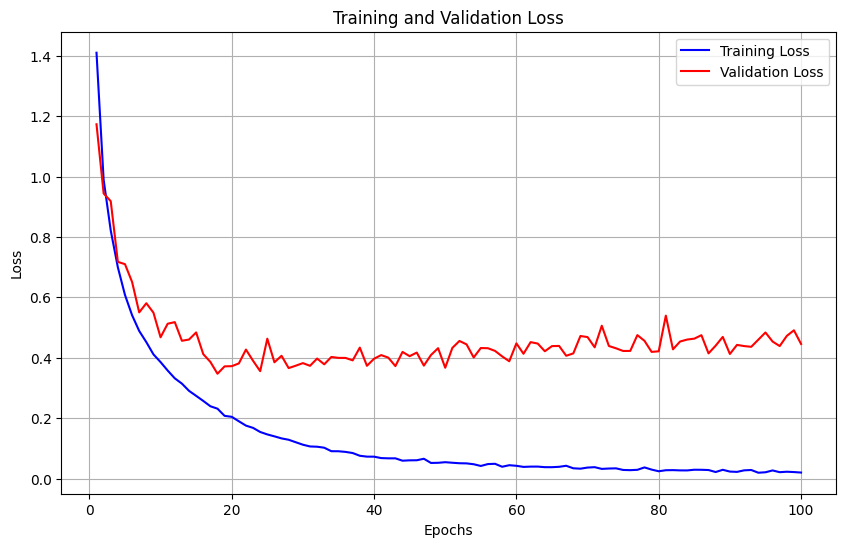

In [27]:
visualize_loss_curve("resnet_10")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotskd_resnet_3.png


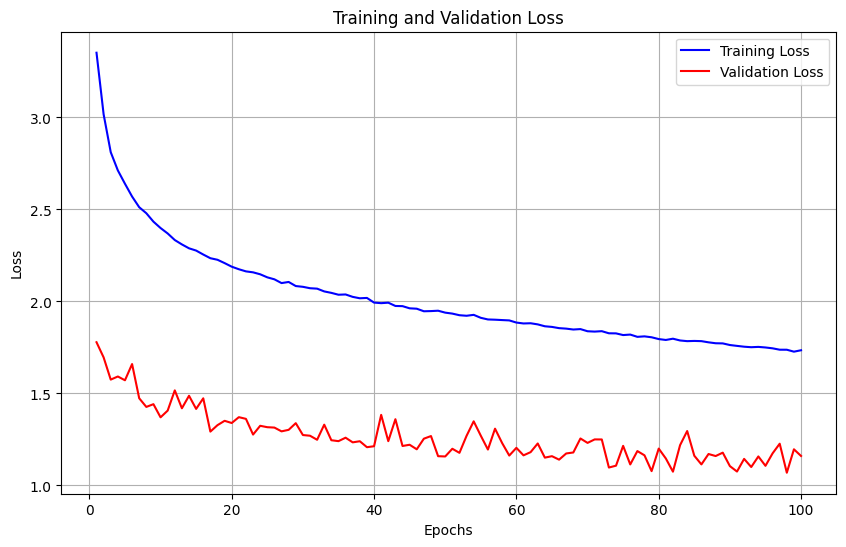

In [28]:
visualize_loss_curve("kd_resnet_3")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotskd_resnet_4.png


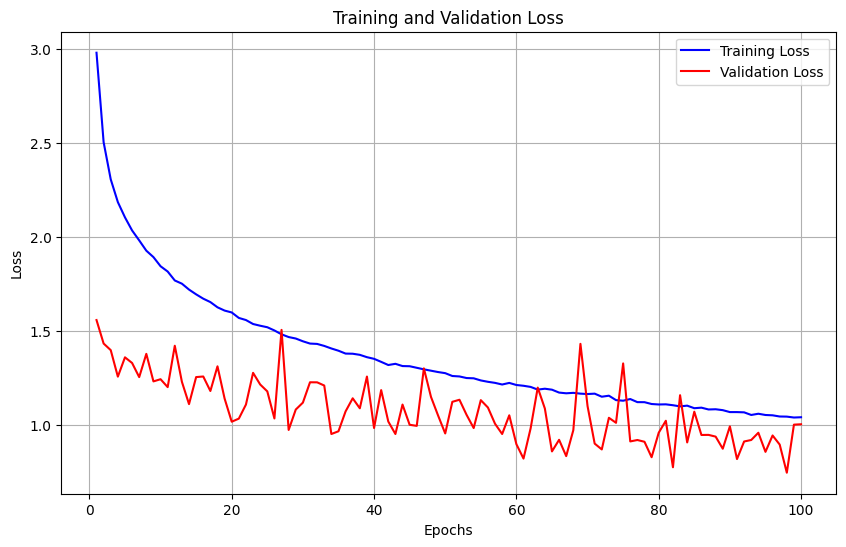

In [29]:
visualize_loss_curve("kd_resnet_4")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotskd_resnet_5.png


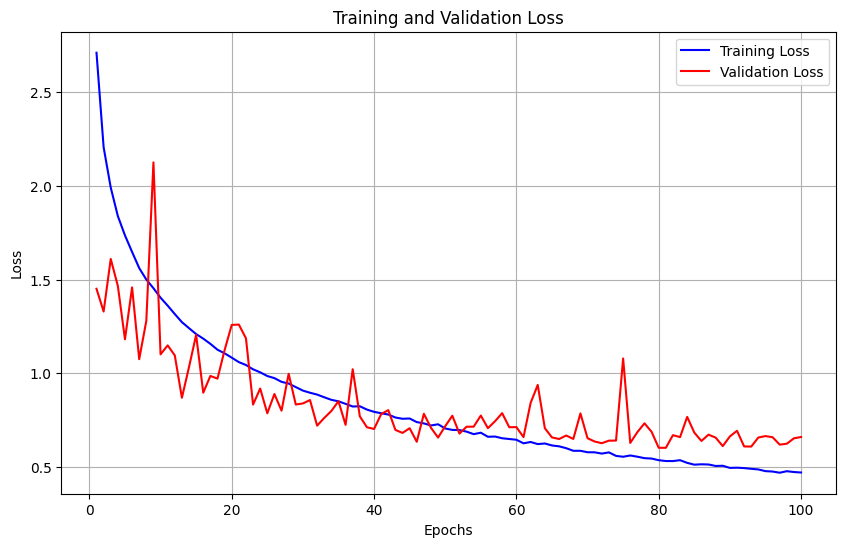

In [30]:
visualize_loss_curve("kd_resnet_5")

Plot saved as /teamspace/studios/this_studio/KnowledgeDistillation/plotskd_resnet_6.png


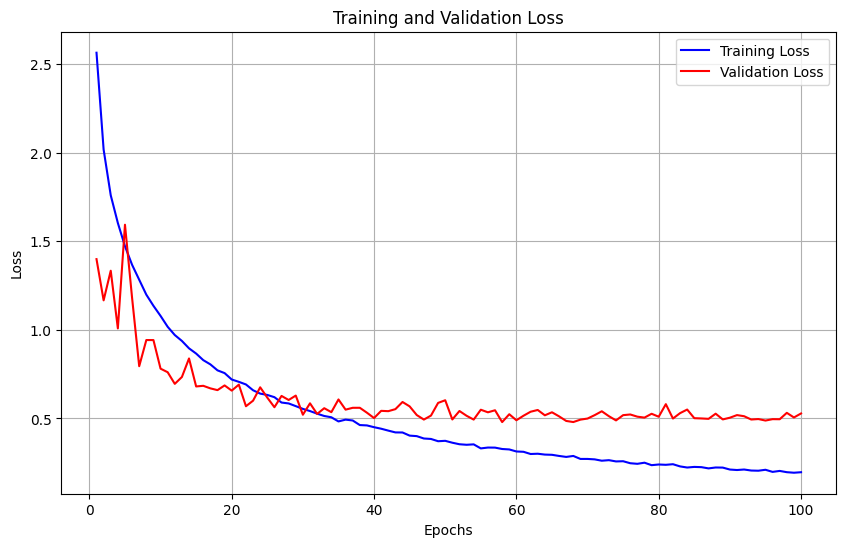

In [31]:
visualize_loss_curve("kd_resnet_6")

## **Parallel Training**

In [47]:
# Function to handle parallel training
def parallel_training(models, model_names, device):
    # Create a list of processes
    processes = []
    for i, model in enumerate(models):
        process = mp.Process(target=training_process, args=( model, device, model_names[i], num_epochs, None ))
        processes.append(process)
        process.start()

    # Wait for all processes to complete
    for process in processes:
        process.join()


In [50]:
# Ensure multiprocessing works well in Jupyter/interactive environments
def set_mp_start_method():
  try:
    # Only set start method if it hasn't been set yet
    mp.set_start_method('spawn', force=True)
  except RuntimeError as e:
    if 'context has already been set' not in str(e):
      raise

def start_training():
  set_mp_start_method()

  # Train the models in parallel
  parallel_training(models, model_names, device=device)

In [51]:
start_training()